# Intruder Detection through Webpage Session Tracking

#### Problem: 
Identification of a specific user by tracking logs of attended Web pages. <br>
https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview

#### Result: 
10th place from out of about 4700 teams on Kaggle; 0.972 roc-auc. Benchmark: simple BOW on sessions: 0.916, the best score: 0.985. <br>
https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard

#### Data:
The data comes from the Blaise Pascal University proxy servers.

The original data contains logs (site name, time of visit) of about 1500 users for 16 months (train) + 6 months (test). The logs were splitted into sessions per 10 sites with a sliding window 10. These values could be additional hyperparameters, but were frozen by the owners of the problem.

#### Main points of the solution:
Remark: for the specific user the name Alice is used in the notebook

- Considering data as time series. 
- Aggregation of some site names (services): over individual session id-s or / and services with multiple ids, that are not used by Alice. It helped to reduce dimensionality of the vectorising space and to deal with new sites in the test set.
- Elementary features, that could be directly extracted from the data: number of unique sites in a session, weekdays, hours, aggregated minutes, session timespan etc. al well as some products of them. 
- Using the number of unique sites of Alice per session as a feature leads to overfitting, but it could be used as an indicator of Alice's time activity. 
- As final vectoriser was used a combination of simple bag of words on sessions with pre-processed site names (each site name - one word) and an additional tf-idf one on the set of common sites (sites used by both types of users). There were also some other vectorisations tested, but all of them worked worse. 
- For classification a base line of few linear algorithms was tested. Simple logistic regression showed the best performance and was used as the final classifier.
- An accurate cross validation was extremely important.

In [5]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings('ignore')

import glob
import os
from tqdm import tqdm_notebook

import numpy as np
from scipy.sparse import csr_matrix, hstack
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
import datetime
from collections import Counter
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.svm import LinearSVC, SVC

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

In [2]:
# project library
# see at the end of the notebook

from alice_lib import *

In [3]:
plt.style.use(['seaborn'])

### Data

In [4]:
def path_(filename): 
    return os.path.join('data', filename) 

PATH_TO_DATA = os.path.join('data')

In [7]:
# site names/id
with open(path_('site_dic.pkl'), 'rb') as handle:
    site_dict = pickle.load(handle)
site_dict_rev = {site_dict[k]: k for k in site_dict}

In [6]:
df_train = pd.read_csv(path_('train_sessions.csv'),  index_col=0)
df_test = pd.read_csv(path_('test_sessions.csv'),  index_col=0)

df_train['time1']= pd.to_datetime(df_train['time1'])
df_train = df_train.sort_values('time1')
df_train.index = range(df_train.shape[0])

df_train.shape, df_test.shape

((253561, 21), (82797, 20))

In [1364]:
# cutted sessions

time_columns = ['time'+str(i) for i in range(1, 11)]
print('by Alice: {:.2f}'.format(df_train[df_train['target']==1].loc[:, 'time10'].isna().sum()/df_train[df_train['target']==1].shape[0]))
print('by other: {:.2f}'.format(df_train[df_train['target']!=1].loc[:, 'time10'].isna().sum()/df_train[df_train['target']!=1].shape[0]))

by Alice: 0.02
by other: 0.09


In [1370]:
# distridution of cutted session lengths
time_columns = ['time'+str(i) for i in range(1, 11)]
print('Alice:')
pd.DataFrame(df_train[df_train['target']==1].isna().sum()).T.loc[:, time_columns]/df_train[df_train['target']==1].loc[:, 'time10'].isna().sum()

Alice:


,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,0.076923,0.25641,0.282051,0.435897,0.615385,0.717949,0.871795,0.897436,1.0


In [1371]:
time_columns = ['time'+str(i) for i in range(1, 11)]
print('not Alice:')
pd.DataFrame(df_train[df_train['target']!=1].isna().sum()).T.loc[:, time_columns]/df_train[df_train['target']!=1].loc[:, 'time10'].isna().sum()

not Alice:


,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,0.153983,0.295149,0.410725,0.521362,0.624922,0.722563,0.814553,0.909746,1.0


In [9]:
# pre-proceced data with features wekday, hour, number of unique sites pro session etc. (see below)

df_train_transformed = pd.read_csv(path_('train_transformed.csv'), index_col=0)
df_test_transformed = pd.read_csv(path_('test_transformed.csv'), index_col=0)
y = df_train_transformed.target.values

## EDA & Feature Engineering

There are three information sources the data: sequence, sites names, visit time. Let's consider the two last ones. Sequences will be reflected in n-gramms by sessions vectorisation. 

### Time

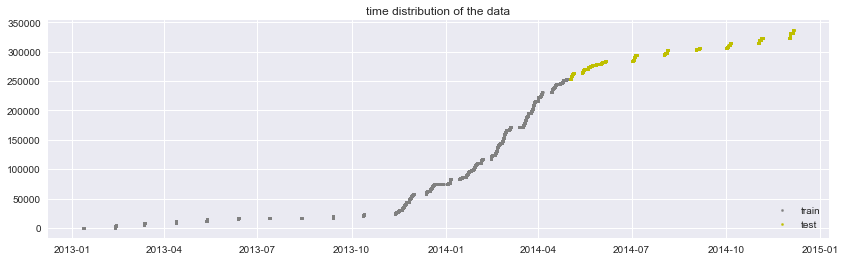

In [1383]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))
tmp = pd.to_datetime(df_train['time1'].rename('train'))
m = len(tmp)
axes.scatter(tmp.values, tmp.index, s=5, c='grey', label='train')
tmp = pd.to_datetime(df_test['time1'].rename('test')).sort_values()
tmp.index = range(m, m+tmp.shape[0])
axes.scatter(tmp.values, tmp.index, s=5, c='y', label='test')
axes.set_title('time distribution of the data')
axes.legend(loc='lower right')

The data is time oriented. If calender time features or any time bases statistics are used, the train data have to be sorted and considered as a time series.

Possible features: 
- week day, hour, minute and there pairwise products
- length on the session
- for popular sites: avg time of the site visit per session / avg time of the site visit, vectorised per popular sites

Text(0.5, 1.0, 'not Alice')

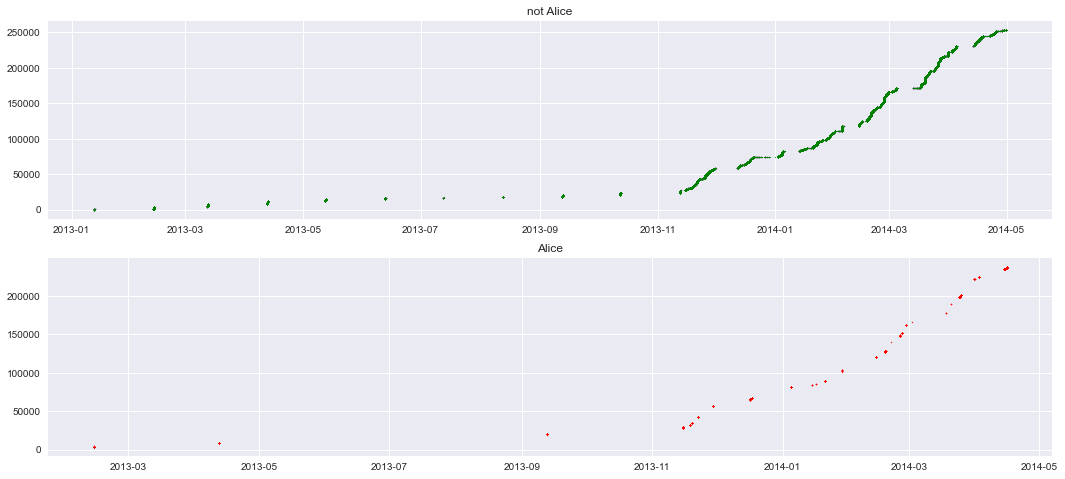

In [1350]:
fig, axs = plt.subplots(2, 1, figsize=(18, 8))
tmp = pd.to_datetime(df_train[df_train['target']==1]['time1'].rename('alice')).sort_values()
axs[1].scatter(tmp.values, tmp.index, s=1, c='red')
axs[1].set_title('Alice')
tmp = pd.to_datetime(df_train[df_train['target']!=1]['time1'].rename('not alice')).sort_values()
axs[0].scatter(tmp.values, tmp.index, s=0.5, c='green')
axs[0].set_title('not Alice')

#### Alice' time of site visits (time diff)

In [12]:
def get_timediff(df):
    time_columns = ['time'+str(i) for i in range(1, 11)]
    site_columns = ['site'+str(i) for i in range(1, 11)]
    a = pd.DataFrame(pd.to_datetime(df.loc[:, time_columns].stack()).sort_values(), columns=['time'])
    a['time_diff'] = pd.to_timedelta(a.time.diff())
    a = a.dropna()
    a['time_diff'] = a['time_diff'].astype(int)/1000000000
    return a

In [13]:
time_split = datetime.datetime(2014, 6, 1)

Let's show on sites visit time distribution in seconds (< 70)

Text(0.5, 0, 'seconds')

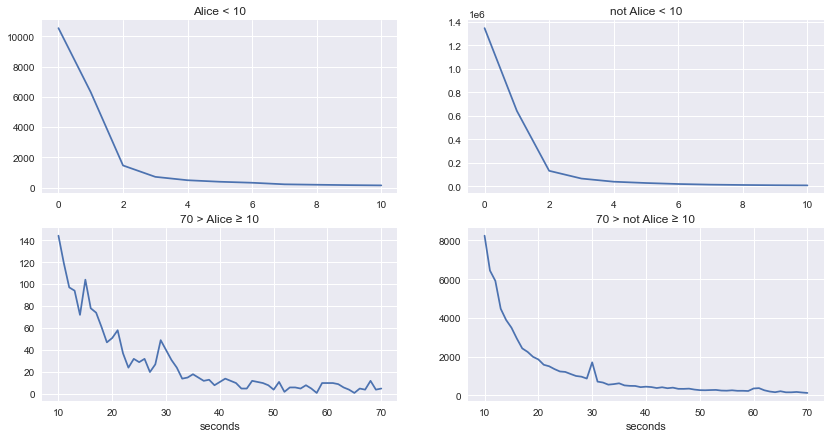

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
alice = get_timediff(df_train[(df_train['target']==1)&(df_train['time1']<time_split)])
alice['time_diff'].value_counts().sort_index()[:10].plot(ax=axes[0, 0])
axes[0, 0].set_title('Alice < 10')

not_alice = get_timediff(df_train[(df_train['target']==0)&(df_train['time1']<time_split)])
not_alice['time_diff'].value_counts().sort_index()[:10].plot(ax=axes[0, 1])
axes[0, 1].set_title('not Alice < 10')

alice = get_timediff(df_train[(df_train['target']==1)&(df_train['time1']<time_split)])
alice['time_diff'].value_counts().sort_index()[10:70].plot(ax=axes[1, 0])
axes[1, 0].set_title('70 > Alice ≥ 10')

not_alice = get_timediff(df_train[(df_train['target']==0)&(df_train['time1']<time_split)])
not_alice['time_diff'].value_counts().sort_index()[10:70].plot(ax=axes[1, 1])
axes[1, 1].set_title('70 > not Alice ≥ 10')

axes[1, 0].set_xlabel('seconds')
axes[1, 1].set_xlabel('seconds')

Now more detailed. 'diff' means difference between Alice's and not Alice distributions, 'share': distribution by Alice.

In [2655]:
for k in range(0, 7):
    a = alice[alice.time_diff==k].shape[0]/alice.shape[0]
    print('sess.length = {} :,  diff: {:.2f}, share: {:.2f}'.format(k, a/(not_alice[not_alice.time_diff==k].shape[0]/
                                                        not_alice.shape[0]), a))
print('----')
for k in range(1, 7):
    a = alice[alice.time_diff>k].shape[0]/alice.shape[0]
    print('sess.length > {} :,  diff: {:.2f}, share: {:.2f}'.format(k, a/(not_alice[not_alice.time_diff>k].shape[0]/
                                                    not_alice.shape[0]), a))
    
print('----')
a = alice[(alice.time_diff>4)&(alice.time_diff<60)].shape[0]/alice.shape[0]
print('{} < sess.length < {} :,  diff: {:.2f}, share: {:.2f}'.format(4, 60, 
                                                                a/(not_alice[(not_alice.time_diff>4)&
                                                                             (not_alice.time_diff<60)].shape[0]/
                                                    not_alice.shape[0]), a))
k=59
a = alice[alice.time_diff>k].shape[0]/alice.shape[0]
print('sess.length > {} :,  diff: {:.2f}, share: {:.2f}'.format(k, a/(not_alice[not_alice.time_diff>k].shape[0]/
                                                    not_alice.shape[0]), a))

sess.length = 0 :,  diff: 0.82, share: 0.46
sess.length = 1 :,  diff: 1.03, share: 0.28
sess.length = 2 :,  diff: 1.16, share: 0.06
sess.length = 3 :,  diff: 1.12, share: 0.03
sess.length = 4 :,  diff: 1.29, share: 0.02
sess.length = 5 :,  diff: 1.42, share: 0.02
sess.length = 6 :,  diff: 1.67, share: 0.01
----
sess.length > 1 :,  diff: 1.54, share: 0.26
sess.length > 2 :,  diff: 1.73, share: 0.20
sess.length > 3 :,  diff: 1.92, share: 0.17
sess.length > 4 :,  diff: 2.07, share: 0.14
sess.length > 5 :,  diff: 2.21, share: 0.13
sess.length > 6 :,  diff: 2.30, share: 0.11
----
4 < sess.length < 60 :,  diff: 1.97, share: 0.13
sess.length > 59 :,  diff: 3.12, share: 0.02


Possible statistics:
- Number of time diff = 0
- Number of time diff ≥ 60
- 5 ≤ Number of time diff ≤ 60

In [1567]:
def pl_(df, figsize=(16,3), title=''):
    n = df[df.target==1].loc[:, columns].shape[0]
    alice = (df[df.target==1].loc[:, columns].stack().astype(int).value_counts().sort_index()/n)
    n = df[df.target==0].loc[:, columns].shape[0]
    not_alice = (df[df.target==0].loc[:, columns].stack().astype(int).value_counts().sort_index()/n)
    for_plot = pd.concat([alice, not_alice], axis=1)
    for_plot.columns=['alice', 'not_alice']
    for_plot.plot.bar(figsize=figsize, grid=True, title=title, rot=0)

#### months / week days / hours / minutes

Fast all figures compare alice's and not alice's distributions of different of corresponding parameters.

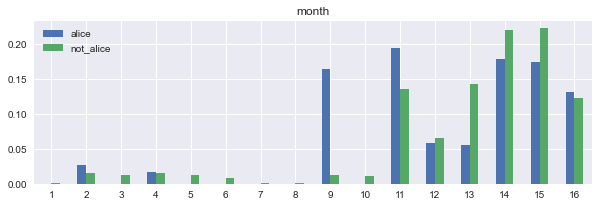

In [1568]:
columns = ['month']
df = df_train_transformed.loc[:, columns + ['target']] # see below
pl_(df, title='month', figsize=(10,3))

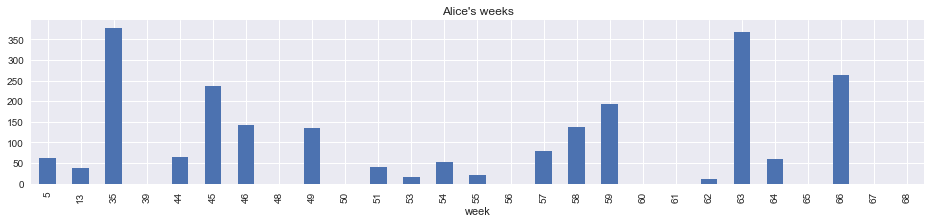

In [1569]:
columns = ['month', 'week']
df_train_transformed[df_train_transformed['month'].isin([2,4,9]+list(range(9, 17)))
                    ].loc[:, columns + ['target']].groupby('week')['target'].sum().plot.bar(figsize=(16,3), 
                                                                                            title='Alice\'s weeks')

Alice uses the internet not every month / week. 

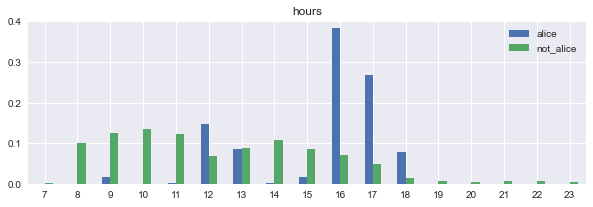

In [1570]:
columns = ['hour']
df = df_train_transformed.loc[:, columns + ['target']] # see below
pl_(df, title='hours', figsize=(10,3))

In [212]:
df = df_train_transformed.loc[:, ['hour', 'month', 'target']]
all_ = pd.pivot_table(df, values='hour', index='target', columns='month', aggfunc='count')
for_plot= pd.DataFrame([], index=range(1, 13))
hours = [9, 12, 13, 15, 16, 17, 18]
for h in hours:
    tmp = pd.pivot_table(df[df.hour==h], values='hour', index='target', columns='month', aggfunc='count')
    tmp = (tmp / all_.loc[:, tmp.columns]).T
    for_plot = pd.concat([for_plot, tmp[1]/tmp[0]], axis=1)
for_plot.columns = hours

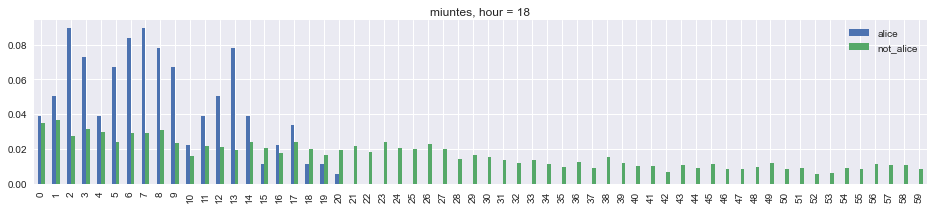

In [1143]:
columns = ['minute']
hour = 18
df = df_train_transformed[df_train_transformed['hour']==hour].loc[:, columns + ['target']]
pl_(df, title='miuntes, hour = '+str(hour))

Minutes can be taken into account, as part of hour for example. And also multiplied on weekdays and hours.

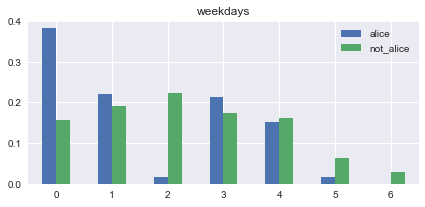

In [1571]:
columns = ['weekday']
df = df_train_transformed.loc[:, columns + ['target', 'month']] 
pl_(df, title='weekdays', figsize=(7,3))

### Sites

#### Number of unique sites in sessions

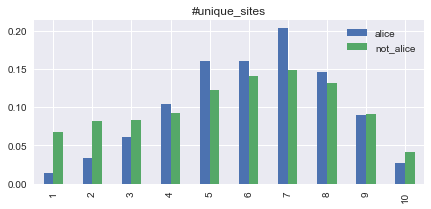

In [1393]:
columns = ['#unique_sites']
df = df_train_transformed.loc[:, columns + ['target']]
pl_(df, title='#unique_sites', figsize=(7,3))

#### Train / Test difference (new sites)

In [1540]:
columns = ['site'+str(i) for i in range(1, 11)]
train_sites = df_train.loc[:, columns].stack().dropna().astype(int).value_counts()
test_sites = df_test.loc[:, columns].stack().dropna().astype(int).value_counts()
alice=df_train[df_train.target==1].loc[:, columns].stack().dropna().astype(int).value_counts()

In [1541]:
new = set(test_sites.index)-set(train_sites.index)
print('new sites: {}'.format(len(new)))
alice_do_not_use_more = set(alice.index) - set(test_sites.index)
print('alice do not use more: {}'.format(len(alice_do_not_use_more)))

new sites: 6770
alice do not use more: 296


In [1542]:
tmp = test_sites[test_sites.index.isin(new)]
tmp.index = tmp.index.map(lambda x: site_dict_rev[x]).values
print('the part of new sites in test: {:.2f}'.format(tmp.sum()/test_sites.sum()))
print('the part of top 5 sites: {:.2f}'.format(sum(test_sites.values[:5])/test_sites.sum()))
print('the part of top 10 sites: {:.2f}'.format(sum(test_sites.values[:10])/test_sites.sum()))

the part of new sites in test: 0.04
the part of top 5 sites: 0.18
the part of top 10 sites: 0.28


#### Sites frequncy

In [1394]:
columns = ['site'+str(i) for i in range(1, 11)]
site_frequqncy = df_train.loc[:, columns].stack().value_counts().sort_values(ascending=False)

Text(0.5, 1.0, 'frequqncy < 100')

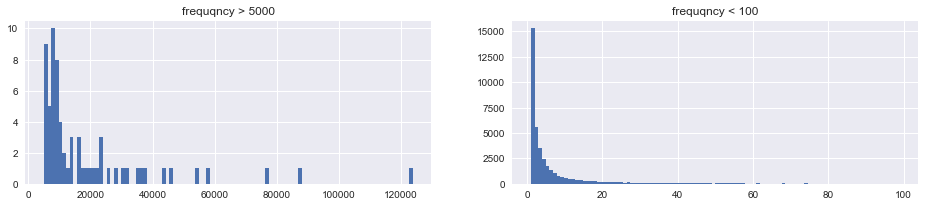

In [1415]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
site_frequqncy[site_frequqncy>5000].hist(bins=100, ax=axes[0])
site_frequqncy[site_frequqncy<100].hist(bins=100, ax=axes[1])
axes[0].set_title('frequqncy > 5000')
axes[1].set_title('frequqncy < 100')

#### Unique sites as the user's activity indicator

In [1453]:
alice_ = Alice(site_dict, site_dict_rev)
alice_.fit(train_stacked, n=50)

In [1487]:
months = [12, 13, 14, 15] 
train, test = [], []
for m in months:
    train.append(train_stacked[(train_stacked.site.isin(alice_.alice_unique_sites[m]))&
                               (train_stacked.month<m)].shape[0])
    test.append(train_stacked[(train_stacked.site.isin(alice_.alice_unique_sites[m]))&
                               (train_stacked.month>=m)].shape[0])

train.append(train_stacked[(train_stacked.target==1)&(train_stacked.site.isin(alice_.alice_unique_sites[16]))].shape[0])
test.append(test_stacked[test_stacked.site.isin(alice_.alice_unique_sites[16])].shape[0])
months = ['dec. 13', 'jan. 14', 'feb. 14', 'mar. 14', 'test']

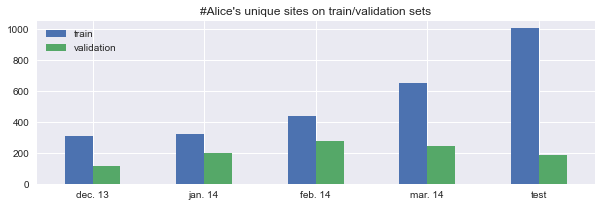

In [1545]:
pd.DataFrame([train, test], index=['train', 'validation'], columns=months).T.plot.bar(title='#Alice\'s unique sites on train/validation sets', 
                                                                                      figsize=(10,3), rot=0 )

Unique sites are taken into account automaticaly by vectorisation (bow or tfidf). Their additionally separation leads to overfitting.  But they can be used as an indicator of Alice's time activity. The idea was inplemented in classes Alice and GetSessions.

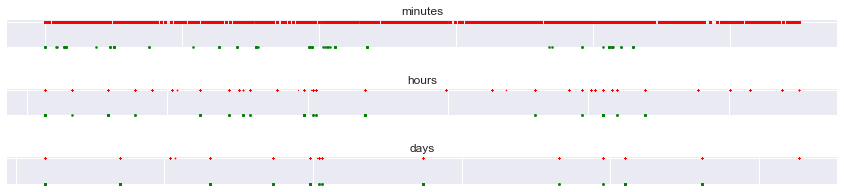

In [1534]:
fig, ax = plt.subplots(3, 1, figsize=(12, 3))

df = alice_.df[(alice_.df.month>13)].copy()
df.minutes_total = df.minutes_total.rank()
df.hours_total = df.hours_total.rank()
df.days_total = df.days_total.rank()

# month>13 - validation, month<14 - train
ax[0].scatter(df[df.site_id.isin(alice_.alice_unique_sites[13])].minutes_total, 
            np.ones(df[df.site_id.isin(alice_.alice_unique_sites[13])].shape[0]), s=5, c='green')
ax[0].scatter(df.minutes_total, 2*np.ones(df.shape[0]), s=5, c='red')
ax[0].set_title('minutes')
minutes = (df[df.site_id.isin(alice_.alice_unique_sites[13])].minutes_total.unique().shape[0]/ 
           df.minutes_total.unique().shape[0])

ax[1].scatter(df[df.site_id.isin(alice_.alice_unique_sites[13])].hours_total, 
            np.ones(df[df.site_id.isin(alice_.alice_unique_sites[13])].shape[0]), s=5, c='green')
ax[1].scatter(df.hours_total, 2*np.ones(df.shape[0]), s=1, c='red')
ax[1].set_title('hours')
hours = (df[df.site_id.isin(alice_.alice_unique_sites[13])].hours_total.unique().shape[0]/ 
           df.hours_total.unique().shape[0])

ax[2].scatter(df[df.site_id.isin(alice_.alice_unique_sites[13])].days_total, 
            np.ones(df[df.site_id.isin(alice_.alice_unique_sites[13])].shape[0]), s=5, c='green')
ax[2].scatter(df.days_total, 2*np.ones(df.shape[0]), s=1, c='red')
ax[2].set_title('days')
days = (df[df.site_id.isin(alice_.alice_unique_sites[13])].days_total.unique().shape[0]/ 
           df.days_total.unique().shape[0])

fig.tight_layout()
for i in range(3):
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])

In [1537]:
# coverage
print('coverage test:')
print('minutes: {:.3f}, hours: {:.3f}, days: {:.3f}'.format(minutes, hours, days))

df = alice_.df[(alice_.df.month<=13)].copy()
df.minutes_total = df.minutes_total.rank()
df.hours_total = df.hours_total.rank()
df.days_total = df.days_total.rank()

minutes = (df[df.site_id.isin(alice_.alice_unique_sites[13])].minutes_total.unique().shape[0]/ 
           df.minutes_total.unique().shape[0])
hours = (df[df.site_id.isin(alice_.alice_unique_sites[13])].hours_total.unique().shape[0]/ 
           df.hours_total.unique().shape[0])
days = (df[df.site_id.isin(alice_.alice_unique_sites[13])].days_total.unique().shape[0]/ 
           df.days_total.unique().shape[0])

print('coverage train:')
print('minutes: {:.3f}, hours: {:.3f}, days: {:.3f}'.format(minutes, hours, days))

coverage test:
minutes: 0.057, hours: 0.472, days: 0.750
coverage train:
minutes: 0.147, hours: 0.571, days: 0.867


#### Platforms / services identification; Sites names pre-processing

It is noticeable, that many sites names contains some additional ids-suffixes. eg.:
<br>i1-js-14-3-01-10077-536503633-i.init.cedexis-radar.net -- > init.cedexis-radar.net
<br>i1-js-14-3-01-11074-716595896-i.init.cedexis-radar.net <br> or
<br>cid-82bc5a860b9d1ab8.users.storage.live.com -- > users.storage.live.com
<br>cid-02b63548e1813f54.users.storage.live.com

In some cases these additional suffixes play a role of user identificator, in some they are individual for each site visit. The variety of such id-s grows over time. On the one hand the individual identificators shoudn't be lost, on the other hand the information about services in new sites names in the test set could be also taken into account. So, some serviseces-space (eg. 'users.storage.live.com') can be extracted and additionally vectorized. The idea is implemented in the class ServiceVectorizer. 

In [1583]:
site_dict_rev[0] = '0'
train_sites.index = train_sites.index.map(lambda x: site_dict_rev[x])
test_sites.index = test_sites.index.map(lambda x: site_dict_rev[x])
alice.index = alice.index.map(lambda x: site_dict_rev[x])
new = set(test_sites.index)-set(train_sites.index)

In [1572]:
service_frequency_ = pd.DataFrame(site_frequency, columns=['freq']).reset_index()
service_frequency_['site'] = service_frequency_['index'].replace(site_dict_rev) 

In [ ]:
def f(service_frequency=service_frequency_, n=2):
    res = service_frequency.copy()
    res['site'] = res.site.map(lambda x: '.'.join(x.split('.')[-n:])).values 
    to_del = set(service_frequency.site.values)&set(res.site.values)
    to_del = res[res.site.isin(to_del)].index
    res.drop(to_del, inplace=True)
    res = res.groupby('site')['freq'].sum().sort_values(ascending=False)
    return res

def g(s, sites):
    counter = 0
    for b in sites: 
        if s in b: counter+= 1
    return counter

In [2138]:
service_frequency = pd.concat([f(n=2), f(n=3), f(n=4)], axis = 0).sort_values(ascending=False)
service_frequency = service_frequency[service_frequency>100] #500 #1
service_frequency = pd.DataFrame(service_frequency, columns=['freq']).reset_index()
service_frequency = service_frequency.groupby('site')['freq'].sum().sort_values(ascending=False)
service_frequency = pd.DataFrame(service_frequency, columns=['freq']).reset_index()

In [2139]:
service_frequency['in_train'] = service_frequency['site'].map(lambda x: g(x, train_sites.index))
service_frequency['alice'] = service_frequency['site'].map(lambda x: g(x, alice.index))
service_frequency['new_in_test'] = service_frequency['site'].map(lambda x: g(x, new))
service_frequency = service_frequency.sort_values('in_train', ascending=False)
service_frequency = service_frequency[(service_frequency.new_in_test>0)&
                                      (service_frequency.in_train>10)& #10
                                      (service_frequency.alice>0)]

In [ ]:
# sites that can be aggregated
to_agregate = service_frequency[service_frequency.alice==0].site.values

Other selected services / specific top-level domains will be used for an additional session vectorization.

In [2141]:
services = service_frequency.site.values[2:]
services_dict = {}
counter = 0
for s in services:
    for a in site_dict_rev: 
        if s in site_dict_rev[a]: services_dict[a] = 's'+str(counter)
    counter += 1 

In [2142]:
no_in_test = {}
 
for m in [13, 14, 15, 16]:
    train = train_stacked[train_stacked.month<m].site.unique()
    test = train_stacked[train_stacked.month>=m].site.unique()
    no_in_test[m] = set(test) - set(train)
train = train_stacked.site.unique()
test = test_stacked.site.unique()
no_in_test['test'] = set(test) - set(train)

'init.cedexis-radar.net' has unique name und should be agregated:

In [384]:
initcedexisradarnet = []
counter = 0
for k in site_dict_rev.keys():
    if 'init.cedexis-radar.net' in  site_dict_rev[k]:
        initcedexisradarnet.append(k)
len(initcedexisradarnet)

6212

In [2108]:
to_agregate_ = []
for a in to_agregate:
    tmp = []
    for k in site_dict_rev.keys():
        if a in  site_dict_rev[k]:
            tmp.append(k)
    to_agregate_.append(tmp)

## Feature preprocessing

In [ ]:
# GetFeatures returns basic features as wekday, hour, number of unique sites pro session etc.  

get_features = GetFeatures(initcedexisradarnet=initcedexisradarnet, to_agregate=to_agregate)
df_train_transformed = get_features.transform(df_train,  minutes_step=10)
df_test_transformed = get_features.transform(df_test,  minutes_step=10)

df_train_transformed.to_csv(path_('train_transformed.csv'))
df_test_transformed.to_csv(path_('test_transformed.csv'))

In [2144]:
%%time
get_features = GetFeatures(initcedexisradarnet=initcedexisradarnet, to_agregate=to_agregate)

df_test_transformed = get_features.sites_agregator(df_test_transformed)
df_train_transformed = get_features.sites_agregator(df_train_transformed)

CPU times: user 10h 38min, sys: 11min 34s, total: 10h 49min 34s
Wall time: 10h 44min 34s


In [2145]:
df_test_transformed = get_features.replace_cedexis_radar(df_test_transformed)
df_train_transformed = get_features.replace_cedexis_radar(df_train_transformed)

In [2146]:
df_train_transformed.to_csv(path_('train_transformed_with_rep.csv'))
df_test_transformed.to_csv(path_('test_transformed_with_rep.csv'))

In [2147]:
y = df_train_transformed.target.values

#### Data stacking

For perfornance goals it is convinient to have stacked data representation.

In [1162]:
train_stacked = stack_df(df_train_transformed, target=True)
test_stacked = stack_df(df_test_transformed)
train_stacked.to_csv(path_('train_stacked.csv'))
test_stacked.to_csv(path_('test_stacked.csv'))

In [2154]:
train_stacked_cv = {}
test_stacked_cv = {}

for k in [13, 14, 15, 16]: 
    train_index = df_train_transformed[df_train_transformed['month']<k].index
    test_index = df_train_transformed[df_train_transformed['month']>=k].index
    train_stacked_cv[k] = stack_df(df_train_transformed.loc[train_index, :]) 
    test_stacked_cv[k] = stack_df(df_train_transformed.loc[test_index, :]) 

In [ ]:
train_stacked.to_csv(path_('train_stacked.csv'))
test_stacked.to_csv(path_('test_stacked.csv'))

resampling: 

In [2155]:
train_stacked_cv_resampled = {}
resampler = Resampler(services_dict)

for k in [13, 14, 15, 16]: 
    train_index = df_train_transformed[df_train_transformed['month']<k].index
    test_index = df_train_transformed[df_train_transformed['month']>=k].index
    df = pd.concat([df_train_transformed.loc[train_index, :],
                    resampler.transform(df_train_transformed.loc[train_index, :], train_stacked_cv[k])[0]], axis=0)
    train_stacked_cv_resampled[k] = stack_df(df) 
    
df = pd.concat([df_train_transformed,
                resampler.transform(df_train_transformed, train_stacked)[0]], axis=0)
train_stacked_resampled = stack_df(df) 

### Features transformation

In [1231]:
train_stacked = pd.read_csv(path_('train_stacked.csv'), index_col=0)
test_stacked = pd.read_csv(path_('test_stacked.csv'), index_col=0)

In [1326]:
df_train_transformed = df_train_transformed.reset_index(drop=True)
df_test_transformed = df_test_transformed.reset_index(drop=True)

In [2157]:
f = lambda x: x['week']*100+x['hour']
df_train_transformed['week_hour'] = df_train_transformed.apply(f, axis=1)
df_test_transformed['week_hour'] = df_test_transformed.apply(f, axis=1)
f = lambda x: x['hour']*100+x['minute']
df_train_transformed['minute_hour'] = df_train_transformed.apply(f, axis=1)
df_test_transformed['minute_hour'] = df_test_transformed.apply(f, axis=1)

#### Sessions vectorization

Some ideas of sessions vectorisation were tested, for example: 
- vectorisation on splitted  per dot site names, 
- on an additional vector space on services (sites names with an id-suffix, such as 'users.storage.live.com' or 'blogpost.fr’), that was constructed to deal with site names in the test set, that do not come across in the train set. Also for this purpose also was implemented a resampling of the train data, that imitated new sites in the test set. 

It turned out, that a combination of simple bag of words on sessions with pre-processed site names (each site name - one word) and an additional tf-idf one on the set of common sites give the best performance (for both n-garamm = (1,1)).

The final feature space consists of 5 blocks: <br>
- one-hot encoded features <br>
- numeric features  <br>
- bag of words on sessions with (1, 1) n-gramms: class Vectoriser  <br>
- probable days of Alice's activity: class UniqueSites  <br>
- tf-idf on an additional vectorisation on the space of sites, common for both kind of users. 

These steps are packed in the class PipeLine.

In [2170]:
class UniqueSites:
    """
    on the base of lists of unique sits, that were got on the training set,
    returns time periods of alice's activity on the test set, as well as 
    vecror representation of uniqke sites
    """
    def __init__(self, alice_, gs):
        self.alice_ = alice_
        self.gs = gs
        self.common = {}
    def fit(self, df_stacked):
        m = df_stacked.month.max()
        self.alice_unique_sites = self.alice_.alice_unique_sites[m]
        self.not_alice_unique_sites = self.alice_.not_alice_unique_sites[m]
        self.common = self.alice_.common[m]
    def transform(self, df_stacked):
        
        minutes = df_stacked[df_stacked['site'].isin(self.alice_unique_sites)]['minutes_total'].unique()
        hours = df_stacked[df_stacked['site'].isin(self.alice_unique_sites)]['hours_total'].unique()
        days = df_stacked[df_stacked['site'].isin(self.alice_unique_sites)]['days_total'].unique()
        
        sites = self.gs.sites(df_stacked, self.alice_unique_sites)
        sites_not_alice = self.gs.sites(df_stacked, self.not_alice_unique_sites)
        
        minutes = self.gs.minutes(df_stacked, minutes)
        hours = self.gs.hours(df_stacked, hours)
        days = self.gs.days(df_stacked, days) # - 1
        return np.vstack([
            #sites, 
            #sites_not_alice, 
            #minutes, 
            #hours, 
            days
        ])

#### Feature transformation pipeline

In [2661]:
class PipeLine:
    def __init__(self, classifier, vectorizer, sv, nv, us, no_transformation, oh_features, resampler):
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.no_transformation = no_transformation
        self.oh_features = oh_features
        self.no_in_test = no_in_test
        self.oh = OneHotEncoder(handle_unknown='ignore')
        self.nv = nv
        self.sv = sv
        self.us = us
        self.resampler = resampler
        self.columns = ['site'+str(i) for i in range(1, 11)]        
    def hstack(self, df, df_stacked):
        oh = self.oh.transform(df.loc[:, self.oh_features])
        d = self.us.transform(df_stacked).T
        dd = np.broadcast_to(d, oh.shape)
        return csr_matrix(hstack([self.vectorizer.transform(df),
                                  self.nv.transform(df), 
                                  #self.sv.transform(df), 
                                  oh, 
                                  csr_matrix(d),
                                  #oh*dd,
                                  csr_matrix(df.loc[:, self.no_transformation].values),
                                 ]))
    def sampler(self, df, y_train, train_index, test_index, df_stacked, m='test'):
        self.X_train, self.X_test = df.loc[train_index, :], df.loc[test_index, :]
        self.y_train, self.y_test = y_train[train_index], y_train[test_index] 

        tmp, y_tmp = self.resampler.transform(self.X_train, df_stacked)
        self.X_train = pd.concat([self.X_train, tmp], axis=0).reset_index(drop=True)
        self.y_train = np.hstack([self.y_train, y_tmp])

        # no in train
        shape = self.X_test.loc[:, self.columns].shape
        X = self.X_test.loc[:, self.columns].values.flatten()
        X = np.where(np.isin(X, self.no_in_test[m]), -3, X).reshape(shape)
        self.X_test.loc[:, self.columns] = X
    def set_input(self, X_train, X_test, y, df_stacked):
        self.X_train, self.X_test = X_train, X_test
        self.y_train = y
        tmp, y_tmp = self.resampler.transform(self.X_train, df_stacked)
        self.X_train = pd.concat([self.X_train, tmp], axis=0).reset_index(drop=True)
        self.y_train = np.hstack([y, y_tmp])
        shape = self.X_test.loc[:, self.columns].shape
        X = self.X_test.loc[:, self.columns].values.flatten()
        X = np.where(np.isin(X, self.no_in_test[m]), -3, X).reshape(shape)
        self.X_test.loc[:, self.columns] = X
    def fit(self, train_stacked):
        self.vectorizer.fit(self.X_train)
        self.oh.fit(self.X_train.loc[:, self.oh_features])
        self.sv.fit(self.X_train)
        self.us.fit(train_stacked)
        self.nv.fit(self.X_train, self.us)
        X_train = self.hstack(self.X_train, train_stacked)
        self.classifier.fit(X_train, self.y_train)
    def predict_proba(self, df_stacked_test):
        X_test = self.hstack(self.X_test, df_stacked_test)
        return self.classifier.predict_proba(X_test).T[1]
    def scores(self, df_stacked_test):
        X_test = self.hstack(self.X_test, df_stacked_test)
        y_pred = self.classifier.predict_proba(X_test).T[1]
        score = roc_auc_score(self.y_test, y_pred) 
        return score

In [2158]:
no_transformation = ['s_0', 's_more_3', 'session_timespan'] 
oh_features = ['#unique_sites', 'weekday', 'hour',  'minute_hour', 'week_hour']

## Classification

In [2159]:
# cross validation on months

def cv_roc_auc(pl, X_train, y_train, kfolds=None):
    scores = [] 
    for k in [13, 14, 15, 16]: 
        train_index = X_train[X_train['month']<k].index
        test_index = X_train[X_train['month']>=k].index
        pl.sampler(X_train, y_train, train_index, test_index, train_stacked_cv[k], k)
        pl.fit(train_stacked_cv_resampled[k])
        score = pl.scores(test_stacked_cv[k])
        #print(score)
        scores.append(score)
    print('{:.4f}'.format(np.array(scores).mean()))
    return scores 

gs = GetSessions()
resampler = Resampler(services_dict)

The baseline of classifiers consisted of: SGD, SVM, Random Forest, Linear Regression, Vowpal Wabbit.  The best performance showed lineal regression.

### SGD

In [2551]:
sgd_logit = SGDClassifier(loss='log', random_state=17,  n_jobs=-1)
nv = NgramVectorizer(type_='tfidf', ngram_range=(1, 1))
sv = ServiceVectorizer(services_dict)
us = UniqueSites(alice_, gs)
pl = PipeLine(classifier=sgd_logit, vectorizer=vectorizer, sv=sv, nv=nv, us=us, no_transformation=no_transformation, 
              oh_features=oh_features, resampler=resampler)
cv_roc_auc(pl, df_train_transformed, y, kfolds=4)

0.9748


[0.964731519953885, 0.9678275236827556, 0.9813549459782399, 0.9852047768184917]

### SVM

In [ ]:
svm =  SVC(kernel='linear', C=0.5, random_state=17, probability=True)
nv = NgramVectorizer(type_='tfidf', ngram_range=(1, 2))
sv = ServiceVectorizer(services_dict)
us = UniqueSites(alice_, gs)
pl = PipeLine(classifier=svm, vectorizer=vectorizer, sv=sv, nv=nv, us=us, no_transformation=no_transformation, 
              oh_features=oh_features, resampler=resampler)
cv_roc_auc(pl, df_train_transformed, y)

### Logistic Regression

In [2163]:
# n - frequency of site of visiting, that limits comon sites space

alice_ = Alice(site_dict, site_dict_rev)
alice_.fit(train_stacked, n=10000) 

In [2634]:
for C in [0.1, 0.3, 0.5, 0.75, 1, 2, 3]:
    logit = LogisticRegression(C=C, random_state=17, solver='liblinear') 
    vectorizer = Vectorizer(vectorizer_='bow', ngram_range=(1, 1))
    nv = NgramVectorizer(type_='tfidf', ngram_range=(1, 1))
    sv = ServiceVectorizer(services_dict)
    us = UniqueSites(alice_, gs)
    pl = PipeLine(classifier=logit, vectorizer=vectorizer, sv=sv, nv=nv, us=us, no_transformation=no_transformation, 
                  oh_features=oh_features, resampler=resampler)
    print('C={}: {}'.format(C, cv_roc_auc(pl, df_train_transformed, y)))

0.9787
C=0.1: [0.967878254236322, 0.9713767367417507, 0.9864042314418098, 0.9892112471770403]
0.9798
C=0.3: [0.9693433351729174, 0.9729959297422356, 0.9872411293127819, 0.9895800696155033]
0.9799
C=0.5: [0.9694787672060701, 0.9732931318170861, 0.9873213921650844, 0.9895389226612993]
0.9799
C=0.75: [0.9693403595419515, 0.973346155181841, 0.9872888469577883, 0.9894444132508622]
0.9797
C=1: [0.9691169059860965, 0.9732761417799273, 0.9872184691785393, 0.9893667269440971]
0.9792
C=2: [0.9681307474102314, 0.9727331576830076, 0.9868646262562253, 0.9890983073600328]
0.9787
C=3: [0.9672880450918769, 0.9721168268161976, 0.986511867079462, 0.9888617123733605]


In [ ]:
logit = LogisticRegression(C=0.75, random_state=17, solver='liblinear') 
vectorizer = Vectorizer(vectorizer_='bow', ngram_range=(1, 1))
nv = NgramVectorizer(type_='tfidf', ngram_range=(1, 1))
sv = ServiceVectorizer(services_dict)
us = UniqueSites(alice_, gs)
pl = PipeLine(classifier=logit, vectorizer=vectorizer, sv=sv, nv=nv, us=us, no_transformation=no_transformation, 
              oh_features=oh_features, resampler=resampler)
cv_roc_auc(pl, df_train_transformed, y)

(96275, 399) (96275, 1) (96275, 399)


In [ ]:
0.9784 + days + ngramms (tfidf 1,2  n=10000)
0.9783 + days + ngramms (tfidf 1,2  n=5000)
0.9782 + days + ngramms (tfidf 1, 1 or 1,2  n=1000)
0.9776 + days + ngramms (tfidf 2, 3) 0.97075 
0.9764 + days + unique alice + unique not alice 
0.9715 + days + hours
0.9772 + days  0.9703  !!
0.9711 + hours - overfitting
0.9603 + minutes
0.9604 base: c=3 + ngramms + sv

### LB prediction

In [2635]:
logit = LogisticRegression(C=0.5, random_state=17, solver='liblinear') 
vectorizer = Vectorizer(vectorizer_='bow', ngram_range=(1, 1))
nv = NgramVectorizer(type_='tfidf', ngram_range=(1, 1))
sv = ServiceVectorizer(services_dict)
us = UniqueSites(alice_, gs)
pl = PipeLine(classifier=logit, vectorizer=vectorizer, sv=sv, nv=nv, us=us, no_transformation=no_transformation, 
              oh_features=oh_features, resampler=resampler)

pl.set_input(df_train_transformed, df_test_transformed, y, train_stacked)
pl.fit(train_stacked_resampled)
logit_test_pred_proba = pl.predict_proba(test_stacked)
write_to_submission_file(logit_test_pred_proba, 'results.csv')

### Vowpal Wabbit

In [2184]:
no_transformation = ['s_0', 's_more_3', 'session_timespan'] 
oh_features = ['#unique_sites', 'weekday', 'hour',  'minute_hour', 'week_hour'] 
sites = ['site'+str(i) for i in range(1, 11)] 

In [2606]:
m = 14
train_index = df_train_transformed[df_train_transformed['month']<m].index
test_index = df_train_transformed[df_train_transformed['month']>=m].index

pl.sampler(df_train_transformed, y, train_index, test_index, train_stacked_cv[m], m=m)
X_train = pl.X_train
y_train_part = pl.y_train
X_valid = pl.X_test
y_valid = pl.y_test
pl.set_input(df_train_transformed, df_test_transformed, y, train_stacked)
X_train_full = pl.X_train
y_train_full = pl.y_train
X_test = pl.X_test

In [2608]:
columns = [sites, oh_features, no_transformation]
XX_train = []
XX_valid = []
XX_train_full = []
XX_test_full = []
for cc in columns: 
    XX_train.append(X_train[cc])
    XX_valid.append(X_valid[cc])
    XX_train_full.append(X_train_full[cc])
    XX_test_full.append(X_test[cc])
y_train = np.where(y_train_part==0, -1, y_train_part)
y_valid = np.where(y_valid==0, -1, y_valid)
y_full = np.where(y_train_full==0, -1, y_train_full)

k=10.1
weights = y_train_full*k + 1
weights_train = y_train_part*k + 1

In [2609]:
def g(XX, df, df_stacked):
    #XX.append(pd.DataFrame(nv.get(df).reshape(1, -1).T))
    XX.append(pd.DataFrame(us.transform(df_stacked).T))
    #XX.append(pd.DataFrame(sv.get(df).reshape(1, -1).T))

In [2610]:
sv.fit(X_train)
us.fit(train_stacked_cv[m])
nv.fit(X_train, us)

g(XX_train, X_train, train_stacked_cv_resampled[m])
g(XX_valid, X_valid, test_stacked_cv[m])

In [2611]:
sv.fit(X_train_full)
us.fit(train_stacked_resampled)
nv.fit(X_train_full, us)

g(XX_train_full, X_train_full, train_stacked_resampled)
g(XX_test_full, X_test, test_stacked)

In [2612]:
def arrays_to_vw(XX_, y_=None, weights=None, train=True, out_file='tmp.vw', words=False):
    XX = [0]*len(XX_)
    for i in range(len(XX_)):
        XX[i] = XX_[i].values.astype('str')
    if y_ is not None : 
        y = np.char.mod('%d', y_)
        w = np.char.mod('%d', weights)
        flag = True
    else: flag = False    
    namespaces = ['bos', 'cat', 'num', 'us'] #'sv', 'nv', 
    g = np.vectorize(lambda x: ' '.join(site_dict_rev[int(x)].split('.'))) 
    with open(out_file, "w") as f: 
        for i in range(XX[0].shape[0]): 
            vw_object = ''
            for k, n in enumerate(namespaces):
                X = XX[k]
                if words and n == 'bos': 
                    vw_object += " |{} {}".format(n, ' '.join(g([X[i]])[0]))
                else: vw_object += " |{} {}".format(n, ' '.join(X[i]))
            if flag: f.write(' '.join([str(y[i]), str(w[i])]) +  vw_object + '\n')
            else: f.write('1' +  vw_object + '\n')    

In [2613]:
train_part_vw = os.path.join(PATH_TO_DATA, 'train_part.vw')
valid_vw = os.path.join(PATH_TO_DATA, 'valid.vw')
train_vw = os.path.join(PATH_TO_DATA, 'train.vw')
test_vw = os.path.join(PATH_TO_DATA, 'test.vw')
model = os.path.join(PATH_TO_DATA, 'vw_model.vw')
pred = os.path.join(PATH_TO_DATA, 'vw_pred.csv')

In [2614]:
flag=False
arrays_to_vw(XX_train, y_=y_train, weights=weights_train, train=True, out_file=train_part_vw, words=flag)
arrays_to_vw(XX_valid, train=False, out_file=valid_vw, words=flag)
arrays_to_vw(XX_train_full, y_=y_full, weights=weights, train=True, out_file=train_vw, words=flag)
arrays_to_vw(XX_test_full, train=False, out_file=test_vw, words=flag)

In [2615]:
!head -3 $PATH_TO_DATA/train_part.vw

-1 1 |bos 56 55 0 0 0 0 0 0 0 0 |cat 2 5 8 800 8 |num 1.0 0.0 0.0 |us 0.0
-1 1 |bos 56 55 56 55 0 0 0 0 0 0 |cat 2 5 8 803 8 |num 1.0 1.0 7.488293515159428 |us 0.0
-1 1 |bos 946 946 951 946 946 945 948 784 949 946 |cat 6 5 8 805 8 |num 5.0 0.0 1.6094379124341003 |us 0.0


In [2616]:
!head -3 $PATH_TO_DATA/test.vw

1 |bos 29 35 22 321 23 2211 6730 21 44582 15336 |cat 10 5 11 1101 9011 |num 7.0 1.0 2.0794415416798357 |us 1.0
1 |bos 782 782 782 782 782 782 782 782 782 782 |cat 1 3 11 1100 7711 |num 0.0 6.0 4.454347296253507 |us 0.0
1 |bos 55 55 55 55 55 55 55 55 1445 1445 |cat 2 4 15 1505 9915 |num 0.0 2.0 4.442651256490317 |us 1.0


In [ ]:
#--ngram c2 --ngram n2  --ngram=2

In [2629]:
%%time
! (rm $PATH_TO_DATA/vw.cache || exit 0)
! vw --final_regressor $PATH_TO_DATA/vw-modell-uebung.vw.bin $PATH_TO_DATA/train_part.vw \
     --loss_function logistic --link logistic --ngram=2 --decay_learning_rate=.95 \
     --learning_rate 0.05 --bit_precision 26 --passes 100 --cache_file $PATH_TO_DATA/vw.cache --random_seed 17

[info] Generating 2-grams for all namespaces.
final_regressor = data/vw-modell-uebung.vw.bin
Num weight bits = 26
learning rate = 0.05
initial_t = 0
power_t = 0.5
decay_learning_rate = 0.95
creating cache_file = data/vw.cache
Reading datafile = data/train_part.vw
num sources = 1
Enabled reductions: gd, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.5000       35
0.606522 0.519897            2            2.0  -1.0000   0.4054       35
0.603106 0.599691            4            4.0  -1.0000   0.4260       35
0.535496 0.467885            8            8.0  -1.0000   0.3497       35
0.493410 0.451324           16           16.0  -1.0000   0.3334       35
0.445880 0.398351           32           32.0  -1.0000   0.2415       35
0.366325 0.286769           64           64.0  -1.0000   0.0932       35
0.304096 0.241868          128  

In [2630]:
!vw -i $PATH_TO_DATA/vw-modell-uebung.vw.bin -t -d $PATH_TO_DATA/valid.vw \
    -p $PATH_TO_DATA/vw_pred.csv  --quiet

In [2631]:
y_pred = pd.read_csv(os.path.join(PATH_TO_DATA, 'vw_pred.csv'), header=None).values
print('{:.4f}'.format(roc_auc_score(y_valid, y_pred)))

0.9695


In [ ]:
vw: 0.9695
log reg: 0.97334

In [2455]:
! (rm $PATH_TO_DATA/vw.cache || exit 0)
! vw --final_regressor $PATH_TO_DATA/vw-modell-uebung.vw.bin $PATH_TO_DATA/train.vw \
     --loss_function logistic --link logistic --decay_learning_rate=.95 \
     --learning_rate 0.05 --bit_precision 26 --passes 70 --cache_file $PATH_TO_DATA/vw.cache --random_seed 17 --quiet
! vw -i $PATH_TO_DATA/vw-modell-uebung.vw.bin -t -d $PATH_TO_DATA/test.vw \
     -p $PATH_TO_DATA/vw_pred.csv --quiet

In [2456]:
write_to_submission_file(pd.read_csv(os.path.join(PATH_TO_DATA, 'vw_pred.csv'), header=None).values, 'results_vw.csv')

## Library

In [2117]:
%%writefile alice_lib_0.py

from __future__ import division, print_function

import warnings
warnings.filterwarnings('ignore')

import glob
import os
from tqdm import tqdm_notebook

import numpy as np
from scipy.sparse import csr_matrix, hstack
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
import datetime

from collections import Counter

from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from random import sample
from random import sample

from matplotlib import pyplot as plt

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

class GetFeatures:
    """
    extract basic features from the original data
    makes sites agregation
    """
    def __init__(self, initcedexisradarnet, to_agregate):
        self.time_columns = ['time'+str(i) for i in range(1, 11)]
        self.site_columns = ['site'+str(i) for i in range(1, 11)]
        self.time_diff_columns = ['time_diff'+str(i) for i in range(1, 10)]
        self.initcedexisradarnet = np.array(initcedexisradarnet)
        self.icrn = self.initcedexisradarnet.min()
        self.to_agregate = to_agregate
        self.to_agregate_min = [min(a) for a in self.to_agregate]
    def fit(self):
        pass
    def session_timespan(self, r):
        l = r.dropna().values
        if len(l) > 1: return l[-1] - l[0]
        else: return np.nan
    def session(self, r):
        l = r[r>0].values
        return pd.Series([len(l), len(np.unique(l))]).T
    def session_in_seconds(self, df):
        def f(x):
            if x == 0: return 0
            elif x > 3: return 1
            else: return 3
        g = lambda x: pd.Series([x[x==0].shape[0], x[x==1].shape[0]])
        return df.loc[:, self.time_diff_columns].applymap(f).apply(g, axis=1).values  
    def replace_cedexis_radar(self, df_):
        def f(x):
            ii = np.where(np.isin(x, self.initcedexisradarnet))[0]
            if len(ii)> 0: x[ii] = [self.icrn]*len(ii)
            return x
        df = df_.copy()
        df.loc[:, self.site_columns] = df.loc[:, self.site_columns].apply(f, axis=1)
        return df
    def sites_agregator(self, df_):
        def f(x, aa, a_min):
            ii = np.where(np.isin(x, aa))[0]
            if len(ii)> 0: x[ii] = [a_min]*len(ii)
            return x
        df = df_.copy()
        for i in range(len(self.to_agregate)):
            aa = self.to_agregate[i]
            a_min = self.to_agregate_min[i]
            df.loc[:, self.site_columns] = df.loc[:, self.site_columns].apply(lambda x: f(x, aa, a_min), axis=1)
        return df
    
    def transform(self, df_, minutes_step=10):
        df = df_.copy()
        for c in self.time_columns: df.loc[:, c] = pd.to_datetime(df.loc[:, c])
        
        d0 = datetime.datetime(2013, 1, 12)
        df['hour'] = df['time1'].map(lambda x: x.hour)
        df['minute'] = df['time1'].map(lambda x: x.minute // minutes_step)
        df['weekday'] = df['time1'].map(lambda x: x.weekday())
        df['month'] = df['time1'].map(lambda x: (x.year - 2013)*12) + df['time1'].map(lambda x: x.month)
        df['week'] = df['time1'].map(lambda x: ((x - d0).days + 5)//7)
        df['day'] = df['time1'].map(lambda x: (x - d0).days)
        
        df.loc[:, 'session_length'] = 0
        df.loc[:, '#unique_sites'] = 0
        df.loc[:, ['session_length', '#unique_sites']] = df.loc[:, self.site_columns].apply(self.session, axis=1).values
        df['session_timespan'] = df.loc[:, self.time_columns].apply(self.session_timespan, axis=1).map(lambda t: t.seconds)
        df['session_timespan'] = df['session_timespan'].fillna(0).map(lambda x: np.log(x + 1))
        
        for t in range(1, 10):
            df.loc[:, 'time_diff'+str(t)] = (df.loc[:, 'time'+str(t+1)] - df.loc[:, 'time'+str(t)]).map(lambda t: t.seconds) 
        df.loc[:, 's_0'] = 0
        df.loc[:, 's_more_3'] = 0
        df.loc[:, ['s_0', 's_more_3']] = self.session_in_seconds(df)
        
        # formatting      
        df.loc[:, self.time_diff_columns] = df.loc[:, self.time_diff_columns].fillna(0)
        df.loc[:, self.site_columns] = df.loc[:, self.site_columns].fillna(0).astype(int)
        return df

class Alice:
    """
    returns (not) alice's unique sites for different time periods and some other statistics for EDA
    """
    def __init__(self, site_dict, site_dict_rev):
        self.alice_unique_sites = {}
        self.not_alice_unique_sites = {}
        self.common = {}
        self.site_dict = site_dict
        self.site_dict_rev = site_dict_rev
    def fit(self, df_stacked, n=50):     
        alice = df_stacked[df_stacked['target']==1].site.unique() 
        not_alice = df_stacked[df_stacked['target']==0].site.unique()         
        alice_unique = set(alice)-set(not_alice) 
        not_alice_unique = set(not_alice) - set(alice)
        
        file = os.path.join('data','train', 'Alice_log.csv')
        alice = pd.read_csv(file)

        # alice unique sites 
        alice['unique'] = 0
        alice_unique = [self.site_dict_rev[k] for k in alice_unique]
        alice.loc[alice[alice['site'].isin(alice_unique)].index, 'unique'] = 1
        
        # alice's total time parameters
        alice['timestamp']= pd.to_datetime(alice['timestamp'])
        f = lambda x: 12*(x.year - 2013)+ x.month
        alice['month']= alice['timestamp'].map(f)
        alice['site_id'] = alice['site'].replace(self.site_dict)
        h0 = datetime.datetime(2013, 1, 12)
        f = lambda x, ss: (x - h0).total_seconds()//ss
        alice['hours_total'] = alice['timestamp'].map(lambda x: f(x, 3600)).astype(int)
        alice['days_total'] = alice['timestamp'].map(lambda x: f(x, 3600*24)).astype(int)
        alice['minutes_total'] = alice['timestamp'].map(lambda x: f(x, 60)).astype(int)
        self.df = alice
        
        # not alice unique sites with limited frquency (n)
        site_frequency = df_stacked.site.dropna().astype(int).value_counts().sort_values(ascending=False)       
        not_alice_unique_short = []
        for c in not_alice_unique:
            if site_frequency[c] < n: not_alice_unique_short.append(c)      
        df_stacked['not_alice'] = 0
        ii = df_stacked[df_stacked['site'].isin(not_alice_unique_short)].index
        df_stacked.loc[ii, 'not_alice']=1
        
        # (not) alice's and unique sites for different periods (for cross validation)
        for m in [12, 13, 14, 15, 16]: #months
            self.alice_unique_sites[m] = alice[(alice['unique']==1)&(alice['month']<=m)].site_id.unique()
            self.not_alice_unique_sites[m] = df_stacked[(df_stacked['not_alice']==1)&
                                                        (df_stacked['month']<=m)].site.unique()
            self.common[m] = (set(df_stacked[df_stacked['month']<=m].site.unique()) - 
                             set(self.not_alice_unique_sites[m]) - set(self.alice_unique_sites[m]))
            
class GetSessions:
    """
    transforms stacked representation to original session represatration
    """
    def sites(self, df, sites_in):
        m = df.sessions.min()
        res = np.zeros(df.sessions.max()-m+1)
        tmp = df[df.site.isin(sites_in)].groupby('sessions')['sessions'].count()
        ii = tmp.index.map(lambda x: x-m)
        res[ii] = tmp.values
        return res
    def minutes(self, df, minutes_in):
        m = df.sessions.min()
        res = np.zeros(df.sessions.max()-m+1)
        tmp = df[df.minutes_total.isin(minutes_in)].groupby('sessions')['sessions'].mean()
        ii = tmp.index.map(lambda x: x-m)
        res[ii] = np.ones(len(ii))
        return res
    def hours(self, df, hours_in):
        m = df.sessions.min()
        res = np.zeros(df.sessions.max()-m+1)
        tmp = df[df.hours_total.isin(hours_in)].groupby('sessions')['sessions'].mean()
        ii = tmp.index.map(lambda x: x-m)
        res[ii] = np.ones(len(ii))
        return res
    def days(self, df, days_in):
        m = df.sessions.min()
        res = np.zeros(df.sessions.max()-m+1)
        tmp = df[df.days_total.isin(days_in)].groupby('sessions')['sessions'].mean()
        ii = tmp.index.map(lambda x: x-m)
        res[ii] = np.ones(len(ii))
        return res  

def stack_df(df, target=False):
    time_columns = ['time'+str(i) for i in range(1, 11)]
    site_columns = ['site'+str(i) for i in range(1, 11)]
    sites = df.loc[:, site_columns].stack().astype(int).reset_index(drop=True)
    time = df.loc[:, time_columns].fillna(datetime.datetime(2013, 1, 11)).stack().reset_index(drop=True)
    res = pd.concat([sites, time], axis=1)
    res.columns=['site', 'time']
    res['sessions'] = res.index.map(lambda x: 1 + x//10)
    res['time']= pd.to_datetime(res['time'])
    f = lambda x: 12*(x.year - 2013)+ x.month
    res['month']= res['time'].map(f)
    h0 = datetime.datetime(2013, 1, 12)
    f = lambda x, ss: (x - h0).total_seconds()//ss
    res['hours_total'] = res['time'].map(lambda x: f(x, 3600)).astype(int)
    res['days_total'] = res['time'].map(lambda x: f(x, 3600*24)).astype(int)
    res['minutes_total'] = res['time'].map(lambda x: f(x, 60)).astype(int)
    if target:
        targets = []
        for t in df.target: targets += [t]*10
        res['target'] = targets
    return res

class Vectorizer:
    """
    vectorisation on all sites
    """
    def __init__(self, vectorizer_, ngram_range, max_features=50000):
        if vectorizer_=='tfidf':
            self.vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
        elif vectorizer_=='bow':
            self.vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
        self.f = lambda x: ' '.join(x)
        self.columns = ['site'+str(i) for i in range(1, 11)]
    def fit(self, df):
        self.vectorizer.fit(df.loc[:, self.columns].astype('str').apply(self.f, axis=1).values)
    def transform(self, df): 
        return self.vectorizer.transform(df.loc[:, self.columns].astype('str').apply(self.f, axis=1).values)
    
class NgramVectorizer:
    """
    an additional vectorisation on the space of sites, common for both kind of users
    """
    def __init__(self, type_='tfidf', ngram_range=(2, 2)):
        if type_=='tfidf':
            self.vectorizer = TfidfVectorizer(ngram_range=ngram_range)
        elif type_=='bow':
            self.vectorizer = CountVectorizer(ngram_range=ngram_range)
        self.columns = ['site'+str(i) for i in range(1, 11)]        
    def get(self, X_train):
        shape = X_train.loc[:, self.columns].shape
        X = X_train.loc[:, self.columns].values.flatten()
        #X = np.where(np.isin(X, self.alice_sites), -1, X).reshape(shape)
        #X = np.where(np.isin(X, self.not_alice_unique_sites), -2, X).reshape(shape)
        X = np.where(np.isin(X, self.common), X, -1).reshape(shape)
        f = lambda x: np.asarray([' '.join(x[np.where(x>0)].astype(str))], dtype=object)
        #f = lambda x: np.asarray([' '.join(x.astype(str))], dtype=object)
        X = np.apply_along_axis(f, 1, X)
        return X.flatten()
    def fit(self, X_train, us):
        self.alice_sites = us.alice_unique_sites
        self.not_alice_unique_sites = us.not_alice_unique_sites
        self.common = np.array(list(us.common))
        self.vectorizer.fit(self.get(X_train))
    def transform(self, X, vectorize=True):
        if vectorize: return self.vectorizer.transform(self.get(X))
        else: return self.get(X)
        
class ServiceVectorizer:
    """
    tfidf on services vector space
    """
    def __init__(self, services_dict):
        self.services_dict = services_dict
        self.sites_in = np.array(list(services_dict.keys()))
        self.vectorizer = TfidfVectorizer()
        self.columns = ['site'+str(i) for i in range(1, 11)]        
    def get(self, X_):
        shape = X_.loc[:, self.columns].shape
        X = X_.loc[:, self.columns].values.flatten()
        X = np.where(np.isin(X, np.array(self.sites_in)), X, -1).reshape(shape)
        def f(x):
            g = np.vectorize(lambda x: self.services_dict[x])
            z = x[np.where(x>0)]
            if len(z)==0: return np.asarray([''], dtype=object)
            else: return np.asarray(' '.join(g(z)), dtype=object)
        X = np.apply_along_axis(f, 1, X)
        return X.flatten()
    def fit(self, X_train):
        self.vectorizer.fit(self.get(X_train))
    def transform(self, X, vectorize=True):
        if vectorize: return self.vectorizer.transform(self.get(X))
        else: return self.get(X) 
        
class Resampler:
    def __init__(self, services_dict):
        self.sites_out = np.array(list(services_dict.keys()))
        self.columns = ['site'+str(i) for i in range(1, 11)] 
    def fit(self):
        return self
    def transform(self, X_, X_stacked):
        ii = (X_stacked[X_stacked.site.isin(self.sites_out)].sessions - 1).unique()
        #ii = sample(list(ii), int(ii.shape[0]*0.75)) #
        X_plus = X_.loc[ii, :]
        shape = X_plus.loc[:, self.columns].shape
        X = X_plus.loc[:, self.columns].values.flatten()
        X_plus.loc[:, self.columns] = np.where(np.isin(X, np.array(self.sites_out)), -3, X).reshape(shape)
        return X_plus, X_.loc[ii, 'target'].values